In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from cmcrameri import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle 
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")
folder_plotting = os.path.join(folder_AGVA, 'Plotting')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [5]:
### create the coastline that was used for calculating distance from ocean

# open ocean shapefile
path_ocean = os.path.join(folder_plotting, 'ne_10m_ocean', 'ne_10m_ocean.shp')
ocean = gpd.read_file(path_ocean)
ocean_orig = ocean.copy().to_crs("EPSG:3338")

# simplify ocean shapefile by filling holes
new_geom = []
for polygon in ocean.geometry.values[0].geoms:
    list_interiors = []
    for interior in polygon.interiors:
        if Polygon(interior).area > 5:
            list_interiors.append(interior)
    new_geom.append(Polygon(polygon.exterior.coords, holes=list_interiors))
ocean['geometry'] = [MultiPolygon(new_geom)]
ocean = ocean.to_crs("EPSG:3338")

# further simplify by buffer in then out
ocean_smooth = ocean.buffer(-20000).buffer(20000)

In [6]:
### create shapefiles showing 100km, 200km from ocean
ocean_100 = ocean_smooth.buffer(100000)
ocean_200 = ocean_smooth.buffer(200000)
ocean_300 = ocean_smooth.buffer(300000)

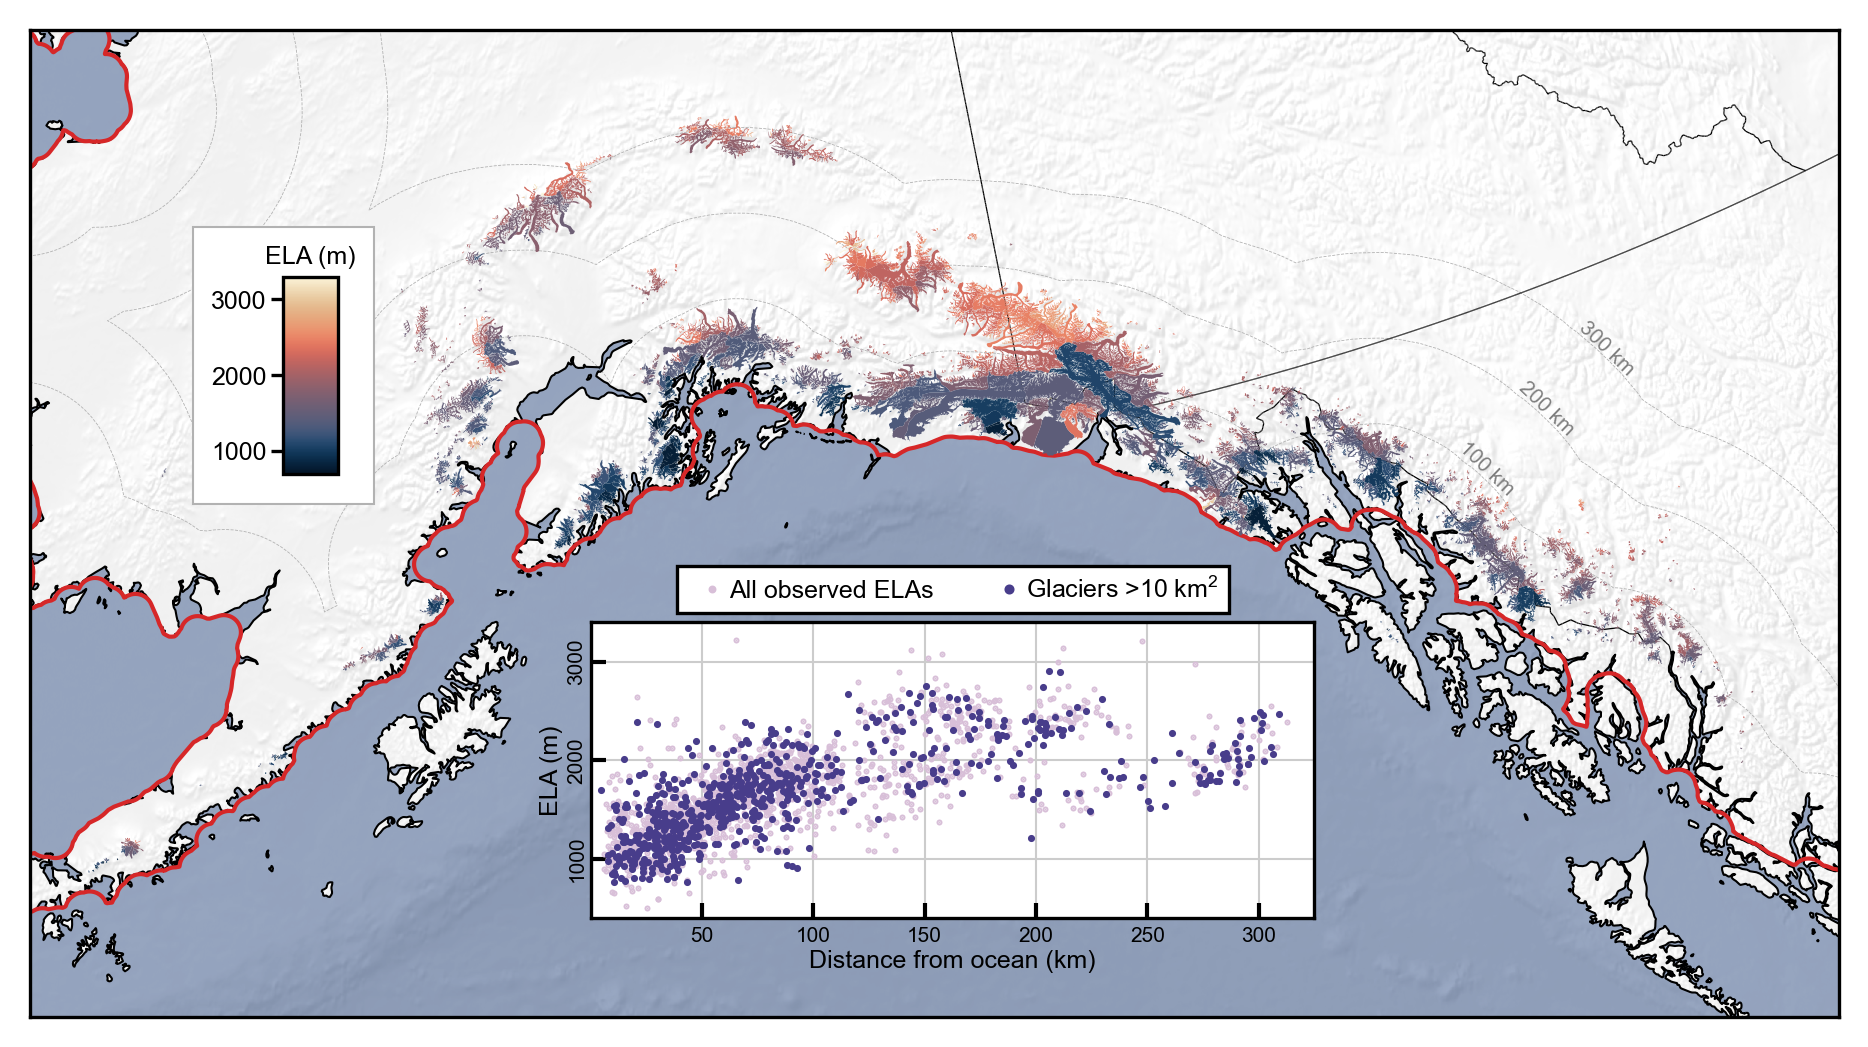

In [7]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

# start figure
fig,axs = snowFun.create_base_map(hillshade=1)

# create inset cbar axis
cb_ax = axs.inset_axes( (0.14,0.55,0.03,0.2), transform=axs.transAxes)

# add glacier data
im = all_data_gdf.plot(ax=axs, column='ela_avg_product', zorder=10, cmap=cm.lipari, legend=True, vmin=700, vmax=3300,
                          legend_kwds={"location":'left', 'cax':cb_ax, 'ticks':[1000,2000,3000]})

# edit cbar axis
cb_ax.tick_params(labelsize=6, length=3, pad=1)
cb_ax.set_xlabel('ELA (m)', size=6, labelpad=3)
cb_ax.xaxis.set_label_position('top') 

# add background to cbar axis
rect = Rectangle((0.09,0.52), 0.1, 0.28, transform=axs.transAxes,
                 fc ='white', ec ='black', lw=0.5, zorder=1.1)
axs.add_patch(rect)

# plot ocean boundary
ocean_smooth.boundary.plot(ax=axs, color='tab:red', linewidth=1, alpha=1, zorder=1.35)

# plot 100 km contours from ocean
ocean_100.boundary.plot(ax=axs, color='black', linewidth=0.2, linestyle='dashed', alpha=1, zorder=1)
ocean_200.boundary.plot(ax=axs, color='black', linewidth=0.2, linestyle='dashed', alpha=1, zorder=1)
ocean_300.boundary.plot(ax=axs, color='black', linewidth=0.2, linestyle='dashed', alpha=1, zorder=1)

# create inset axis for scatterplot
ax_sc = axs.inset_axes( (0.31,0.1,0.4,0.3), transform=axs.transAxes)

# subset data for scatterplot data
subset_df = all_data_gdf[all_data_gdf['off_glacier_avg_product']==0] # only glaciers with ela on glacier
subset_df_big = subset_df[subset_df['Area']>10]

# add data to plot
ax_sc.scatter(subset_df['distance_from_ocean'], subset_df['ela_avg_product'],
           s=0.2, c='thistle', edgecolor=None, zorder=2, label='All observed ELAs')
ax_sc.scatter(subset_df_big['distance_from_ocean'], subset_df_big['ela_avg_product'],
           s=0.5, c='darkslateblue', zorder=3, label='Glaciers >10 km$^2$')

# edit scatterplot axis
ax_sc.set_xlim(0.1,325)
ax_sc.set_ylim(400,3400)
ax_sc.set_xlabel('Distance from ocean (km)', size=6, labelpad=1)
ax_sc.set_ylabel('ELA (m)', size=6, labelpad=1)
ax_sc.set_yticks([1000,2000,3000])
ax_sc.set_yticklabels([1000,2000,3000], va='center')
ax_sc.tick_params(axis="x", pad=2, direction="in", width=1, labelsize=5, zorder=2)
ax_sc.tick_params(axis="y" ,pad=1, direction="in", labelrotation=90, width=1, labelsize=5, zorder=2)
ax_sc.grid(c='0.8', linewidth=0.5, zorder=1)

l = ax_sc.legend(fontsize=6, fancybox=False, ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99),
                 markerscale=2, scatteryoffsets=[0.5], labelspacing=0.2, handletextpad=-0.3,
                 framealpha=1, facecolor='white', edgecolor='black')
l.get_frame().set_linewidth(0.8)

# remove map ticks and labels
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")

# add labels to show distance from coast
axs.text(0.788,0.528, "100 km", fontsize=5, color='grey', rotation=-44, transform=axs.transAxes)
axs.text(0.821,0.589, "200 km", fontsize=5, color='grey', rotation=-44, transform=axs.transAxes)
axs.text(0.854,0.65, "300 km", fontsize=5, color='grey', rotation=-44, transform=axs.transAxes)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'ela map', 'ela_map_hillshade.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)


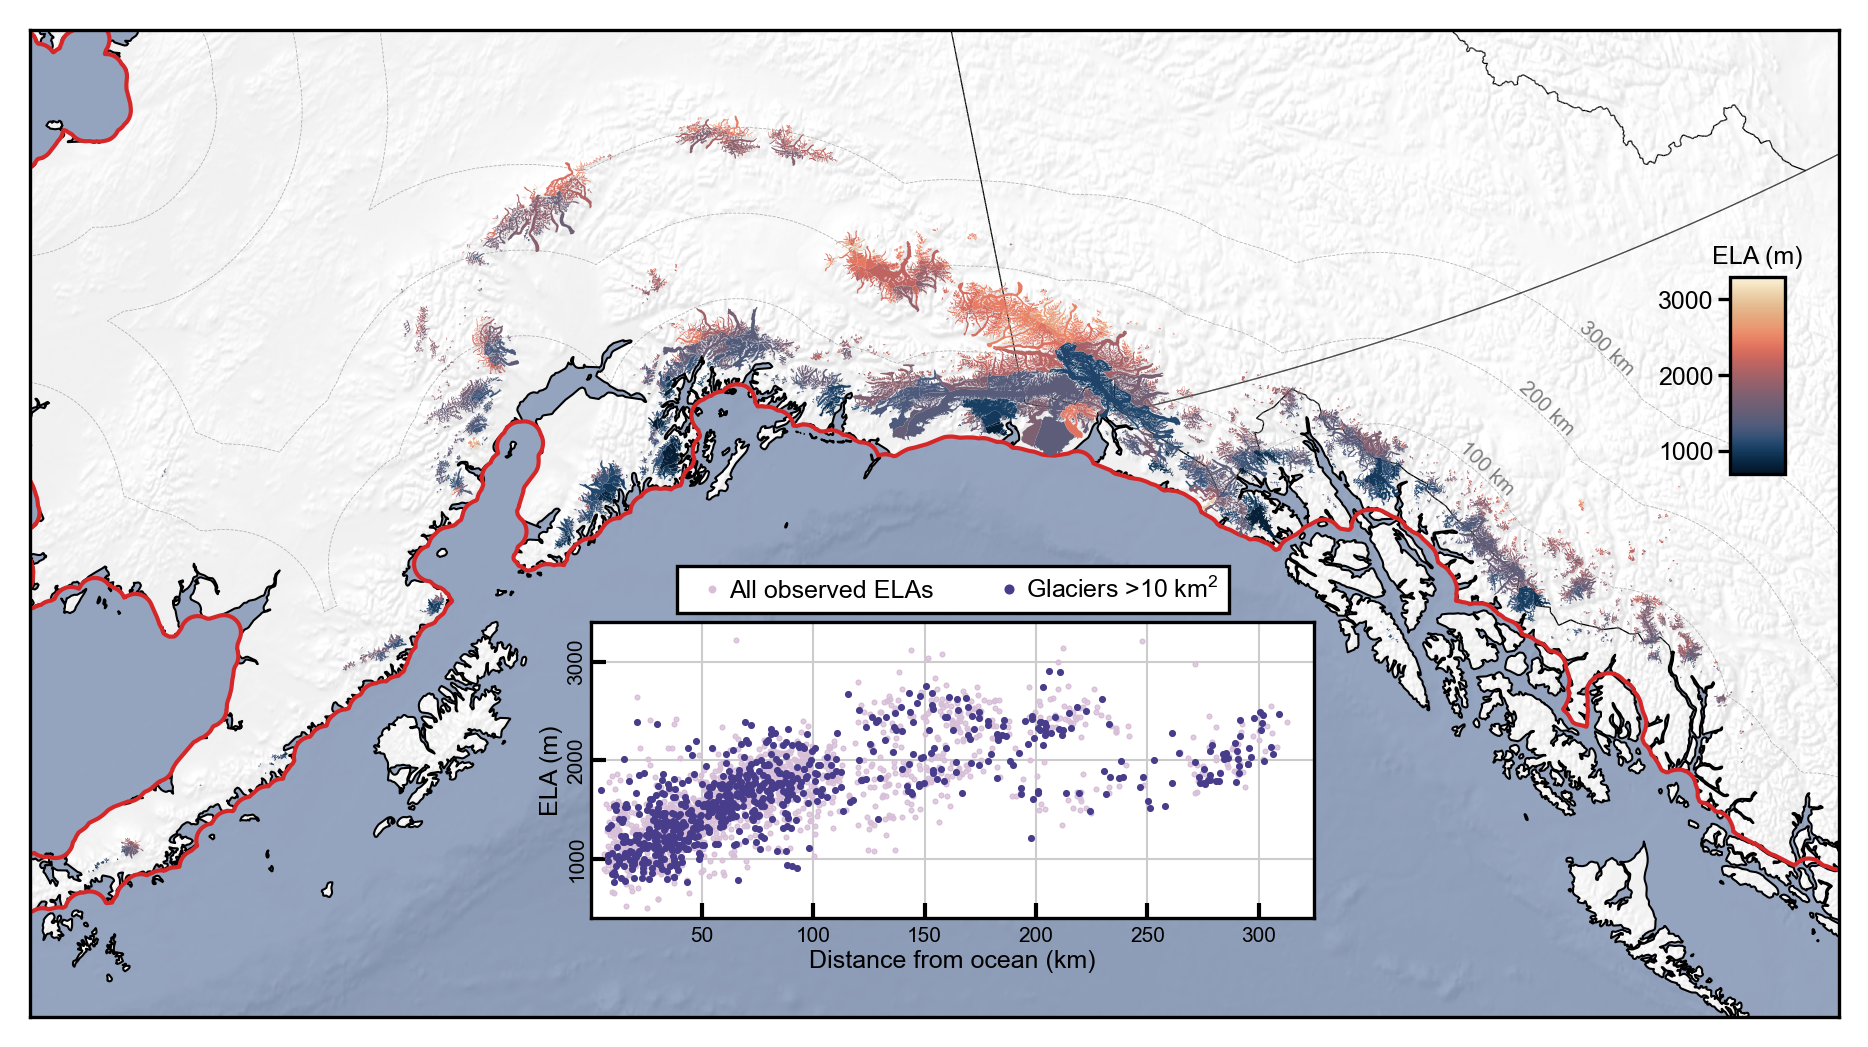

In [11]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

# start figure
fig,axs = snowFun.create_base_map(hillshade=1)

# create inset cbar axis
cb_ax = axs.inset_axes( (0.94,0.55,0.03,0.2), transform=axs.transAxes)
                        
# add glacier data
im = all_data_gdf.plot(ax=axs, column='ela_avg_product', zorder=10, cmap=cm.lipari, legend=True, vmin=700, vmax=3300,
                          legend_kwds={"location":'left', 'cax':cb_ax, 'ticks':[1000,2000,3000]})

# edit cbar axis
cb_ax.tick_params(labelsize=6, length=3, pad=1)
cb_ax.set_xlabel('ELA (m)', size=6, labelpad=3)
cb_ax.xaxis.set_label_position('top') 

# add background to cbar axis
# rect = Rectangle((0.79,0.67), 0.1, 0.28, transform=axs.transAxes,
#                  fc ='white', ec ='black', lw=0.5, zorder=1.1)
# axs.add_patch(rect)

# plot ocean boundary
ocean_smooth.boundary.plot(ax=axs, color='tab:red', linewidth=1, alpha=1, zorder=1.35)

# plot 100 km contours from ocean
ocean_100.boundary.plot(ax=axs, color='black', linewidth=0.2, linestyle='dashed', alpha=1, zorder=1)
ocean_200.boundary.plot(ax=axs, color='black', linewidth=0.2, linestyle='dashed', alpha=1, zorder=1)
ocean_300.boundary.plot(ax=axs, color='black', linewidth=0.2, linestyle='dashed', alpha=1, zorder=1)

# create inset axis for scatterplot
ax_sc = axs.inset_axes( (0.31,0.1,0.4,0.3), transform=axs.transAxes)

# subset data for scatterplot data
subset_df = all_data_gdf[all_data_gdf['off_glacier_avg_product']==0] # only glaciers with ela on glacier
subset_df_big = subset_df[subset_df['Area']>10]

# add data to plot
ax_sc.scatter(subset_df['distance_from_ocean'], subset_df['ela_avg_product'],
           s=0.2, c='thistle', edgecolor=None, zorder=2, label='All observed ELAs')
ax_sc.scatter(subset_df_big['distance_from_ocean'], subset_df_big['ela_avg_product'],
           s=0.5, c='darkslateblue', zorder=3, label='Glaciers >10 km$^2$')

# edit scatterplot axis
ax_sc.set_xlim(0.1,325)
ax_sc.set_ylim(400,3400)
ax_sc.set_xlabel('Distance from ocean (km)', size=6, labelpad=1)
ax_sc.set_ylabel('ELA (m)', size=6, labelpad=1)
ax_sc.set_yticks([1000,2000,3000])
ax_sc.set_yticklabels([1000,2000,3000], va='center')
ax_sc.tick_params(axis="x", pad=2, direction="in", width=1, labelsize=5, zorder=2)
ax_sc.tick_params(axis="y" ,pad=1, direction="in", labelrotation=90, width=1, labelsize=5, zorder=2)
ax_sc.grid(c='0.8', linewidth=0.5, zorder=1)

l = ax_sc.legend(fontsize=6, fancybox=False, ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99),
                 markerscale=2, scatteryoffsets=[0.5], labelspacing=0.2, handletextpad=-0.3,
                 framealpha=1, facecolor='white', edgecolor='black')
l.get_frame().set_linewidth(0.8)

# remove map ticks and labels
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")

# add labels to show distance from coast
axs.text(0.788,0.528, "100 km", fontsize=5, color='grey', rotation=-44, transform=axs.transAxes)
axs.text(0.821,0.589, "200 km", fontsize=5, color='grey', rotation=-44, transform=axs.transAxes)
axs.text(0.854,0.65, "300 km", fontsize=5, color='grey', rotation=-44, transform=axs.transAxes)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'ela map', 'ela_map_hillshade_dis.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)


Best fit: ELA = 1027 + 8.594*distance


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


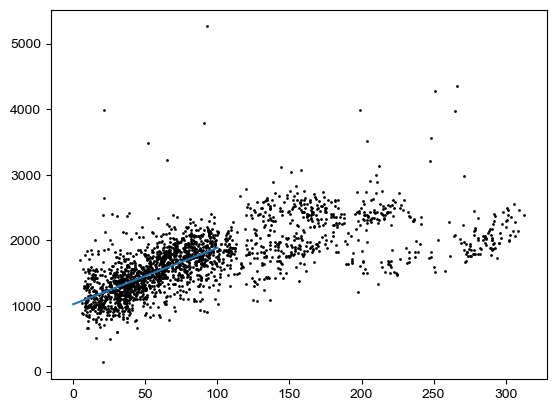

In [7]:
# subset data for scatterplot data
subset_df = all_data_gdf[all_data_gdf['off_glacier_avg_product']==0] # only glaciers with ela on glacier
subset_df_big = subset_df[subset_df['Area']>10]

# fit linear regression to first 100 km
df = subset_df_big
df = df[df['distance_from_ocean']<=100]
lr100 = LinearRegression().fit(df[['distance_from_ocean']], df['ela_avg_product'])
print("Best fit:", f"ELA = {round(lr100.intercept_)} + {round(lr100.coef_[0],3)}*distance" )
# print(lr100.intercept_)

fig,axs = plt.subplots()
axs.scatter(subset_df['distance_from_ocean'], subset_df['ela_avg_product'], c='black',s=1)
axs.plot([0,100], [lr100.predict([[0]]),lr100.predict([[100]])] )